In [5]:
import os
DATA_PATH = "../data"
print("Files in data/:", os.listdir(DATA_PATH))


Files in data/: ['test (1).csv', 'test_cleaned.csv', 'train.csv', 'train_cleaned.csv']


In [7]:
import pandas as pd, re

DATA_PATH = "../data"

# load cleaned versions
train = pd.read_csv(f"{DATA_PATH}/train_cleaned.csv")
test  = pd.read_csv(f"{DATA_PATH}/test_cleaned.csv")

def clean_cols(df):
    df = df.copy()
    df.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', c).lower().strip('_') for c in df.columns]
    return df

train = clean_cols(train)
test  = clean_cols(test)

print("train shape:", train.shape)
print("test shape:", test.shape)
print("columns:", train.columns.tolist())
print("fake value counts:\n", train['fake'].value_counts())
train.head()


train shape: (576, 12)
test shape: (120, 12)
columns: ['profile_pic', 'nums_length_username', 'fullname_words', 'nums_length_fullname', 'name__username', 'description_length', 'external_url', 'private', 'posts', 'followers', 'follows', 'fake']
fake value counts:
 fake
0    288
1    288
Name: count, dtype: int64


,profile_pic,nums_length_username,fullname_words,nums_length_fullname,name__username,description_length,external_url,private,posts,followers,follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [8]:
# Cell 2 - Feature Engineering
df = train.copy()
import numpy as np

# log transforms for skewed features
for c in ['posts','followers','follows']:
    df[f'log_{c}'] = np.log1p(df[c].astype(float))

# follower/following ratio
df['foll_ratio'] = df['followers'] / (df['follows'] + 1)

# boolean fields ko int me convert
for b in ['profile_pic','external_url','private','name__username']:
    df[f'{b}_int'] = df[b].astype(int)

# description length per word
df['desc_per_word'] = df['description_length'] / (df['fullname_words'] + 1)

print("New features added:", [c for c in df.columns if c not in train.columns])
df.head()


New features added: ['log_posts', 'log_followers', 'log_follows', 'foll_ratio', 'profile_pic_int', 'external_url_int', 'private_int', 'name__username_int', 'desc_per_word']


,profile_pic,nums_length_username,fullname_words,nums_length_fullname,name__username,description_length,external_url,private,posts,followers,follows,fake,log_posts,log_followers,log_follows,foll_ratio,profile_pic_int,external_url_int,private_int,name__username_int,desc_per_word
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0,3.496508,6.908755,6.862758,1.046025,1,0,0,0,53.000000
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0,5.659482,7.916078,6.280396,5.131086,1,0,0,0,14.666667
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0,2.639057,5.075174,4.595120,1.606061,1,0,1,0,0.000000
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0,6.522093,6.028279,6.480045,0.634969,1,0,0,0,41.000000
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0,1.945910,5.023881,4.844187,1.188976,1,0,1,0,0.000000


In [9]:
# Cell 3 - Baseline Model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

# select numeric features only
features = [c for c in df.columns if df[c].dtype in [int, float] and c not in ['fake']]
X = df[features].fillna(0)
y = df['fake']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
y_proba = pipe.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))


              precision    recall  f1-score   support

           0       0.90      0.95      0.92        58
           1       0.95      0.90      0.92        58

    accuracy                           0.92       116
   macro avg       0.92      0.92      0.92       116
weighted avg       0.92      0.92      0.92       116

ROC-AUC: 0.9224137931034483


In [10]:
# Cell 4 - RandomForest with GridSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
from sklearn.pipeline import make_pipeline
pipe_rf = make_pipeline(StandardScaler(), rf)

param_grid = {
    'randomforestclassifier__n_estimators': [100, 300],
    'randomforestclassifier__max_depth': [None, 10, 30],
    'randomforestclassifier__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe_rf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
best = gs.best_estimator_

y_pred = best.predict(X_val)
y_proba = best.predict_proba(X_val)[:,1]

print("Best params:", gs.best_params_)
print(classification_report(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        58
           1       0.89      0.95      0.92        58

    accuracy                           0.91       116
   macro avg       0.92      0.91      0.91       116
weighted avg       0.92      0.91      0.91       116

ROC-AUC: 0.9852853745541023


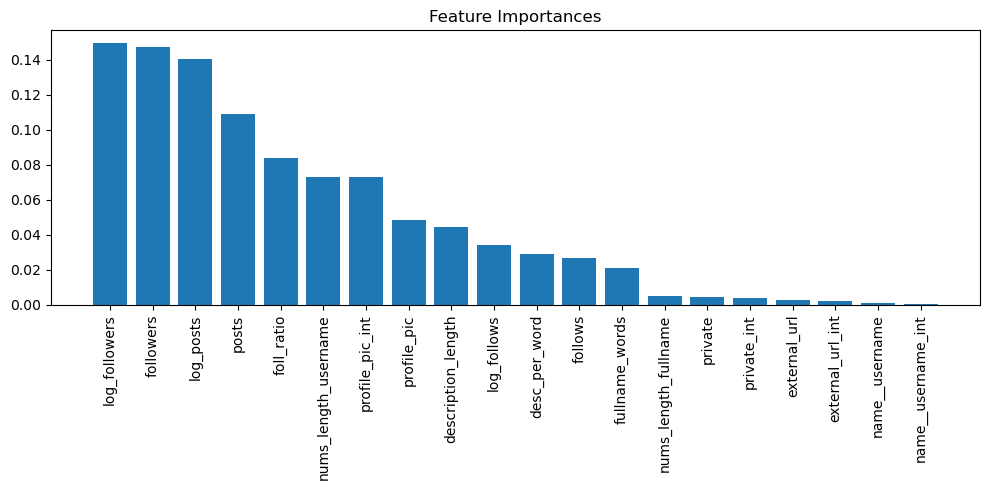

In [11]:
# Cell 5 - Feature Importance
import matplotlib.pyplot as plt
import numpy as np

rf_model = best.named_steps['randomforestclassifier']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Feature Importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [12]:
import joblib
import os

os.makedirs("../outputs", exist_ok=True)
joblib.dump(best, "../outputs/best_model.pkl")
print("Model saved as ../outputs/best_model.pkl")


Model saved as ../outputs/best_model.pkl


In [13]:
# Load model
import joblib
best = joblib.load("../outputs/best_model.pkl")

# Prepare test data
test_df = test.copy()
for c in ['posts','followers','follows']:
    test_df[f'log_{c}'] = np.log1p(test_df[c].astype(float))

test_df['foll_ratio'] = test_df['followers'] / (test_df['follows'] + 1)

for b in ['profile_pic','external_url','private','name__username']:
    test_df[f'{b}_int'] = test_df[b].astype(int)

test_df['desc_per_word'] = test_df['description_length'] / (test_df['fullname_words'] + 1)

X_test = test_df[[c for c in test_df.columns if c in X.columns]].fillna(0)

# Predict
test_preds = best.predict(X_test)
test_probs = best.predict_proba(X_test)[:,1]

# Save submission
import pandas as pd
submission = pd.DataFrame({
    "id": test_df.index,
    "fake_prediction": test_preds,
    "fake_probability": test_probs
})
submission.to_csv("../outputs/test_predictions.csv", index=False)
submission.head()


,id,fake_prediction,fake_probability
0,0,0,0.113333
1,1,0,0.380000
2,2,0,0.043333
3,3,0,0.020000
4,4,0,0.500000


In [14]:
# Install shap (if not done already)
!pip install shap

import shap

# Explain with SHAP
explainer = shap.TreeExplainer(best.named_steps['randomforestclassifier'])
shap_values = explainer.shap_values(X_val)

# Summary plot
shap.summary_plot(shap_values[1], X_val, feature_names=features)


   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.1 kB ? eta -:--:--
   -------------------------------------- 545.1/545.1 kB 639.8 kB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

X_model.shape: (116, 20)
shap shape: (116, 20, 2)


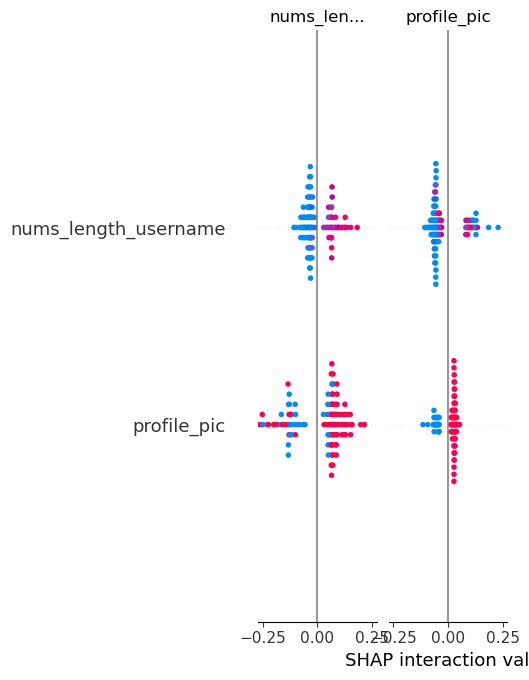

In [15]:
import shap, numpy as np

# pick transformed X used by the model
scaler = best.named_steps.get('standardscaler', None)
if scaler is not None:
    X_model = scaler.transform(X_val)
else:
    # fallback: try transform with whole pipeline excluding the final estimator (if named)
    # this assumes pipeline steps like ('scaler','randomforestclassifier')
    from sklearn.pipeline import Pipeline
    steps = list(best.named_steps.keys())
    # create a new pipeline without final estimator
    prepipe = Pipeline([(name, best.named_steps[name]) for name in steps if name != 'randomforestclassifier'])
    X_model = prepipe.transform(X_val)

print("X_model.shape:", X_model.shape)

explainer = shap.TreeExplainer(best.named_steps['randomforestclassifier'])
shap_values = explainer.shap_values(X_model)
sv = shap_values[1] if isinstance(shap_values, list) else shap_values
print("shap shape:", np.array(sv).shape)

# now plot (this will open matplotlib)
shap.summary_plot(sv, X_model, feature_names=features)


In [16]:
# Test set predictions
import pandas as pd
import numpy as np
import joblib

best = joblib.load("../outputs/best_model.pkl")

test_df = test.copy()
for c in ['posts','followers','follows']:
    test_df[f'log_{c}'] = np.log1p(test_df[c].astype(float))
test_df['foll_ratio'] = test_df['followers'] / (test_df['follows'] + 1)
for b in ['profile_pic','external_url','private','name__username']:
    test_df[f'{b}_int'] = test_df[b].astype(int)
test_df['desc_per_word'] = test_df['description_length'] / (test_df['fullname_words'] + 1)

X_test = test_df[[c for c in test_df.columns if c in features]].fillna(0)

preds = best.predict(X_test)
probs = best.predict_proba(X_test)[:,1]

submission = pd.DataFrame({
    "id": test_df.index,
    "fake_prediction": preds,
    "fake_probability": probs
})

submission.to_csv("../outputs/test_predictions.csv", index=False)
submission.head()


,id,fake_prediction,fake_probability
0,0,0,0.113333
1,1,0,0.380000
2,2,0,0.043333
3,3,0,0.020000
4,4,0,0.500000
